[Reference](https://medium.com/swlh/anomaly-detection-in-time-series-data-using-keras-60763157cecc)

# Step 1: Importing the libraries

In [26]:
import numpy as np 
import tensorflow as tf 
import pandas as pd 
pd.options.mode.chained_assignment = None 
import seaborn as sns 
from matplotlib.pylab import rcParams 
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
%matplotlib inline 
sns.set(style='whitegrid', palette='muted') 
rcParams['figure.figsize'] = 14, 8 
np.random.seed(1) 
tf.random.set_seed(1) 
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.7.0


# Step 2: Loading S&P 500 Index Data

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/Branden-Kang/Time-Series-Analysis/master/Data/spx.csv', parse_dates=['date']) 
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [28]:
df.shape

(8192, 2)

In [29]:
fig = go.Figure() 
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close')) 
fig.update_layout(showlegend=True)
fig.show()

# Task 3: Data Preprocessing

In [30]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size 
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] 
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [31]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler = scaler.fit(train[['close']]) 
train['close'] = scaler.transform(train[['close']]) 
test['close'] = scaler.transform(test[['close']])

# Task 4: Create Training and Test Splits

In [32]:
def create_dataset(X, y, time_steps=1): 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)    
        ys.append(y.iloc[i + time_steps]) 
    return np.array(Xs), np.array(ys)

In [33]:
time_steps = 30 
X_train, y_train = create_dataset(train[['close']], train.close, time_steps) 
X_test, y_test = create_dataset(test[['close']], test.close, time_steps) 
print(X_train.shape)

(6523, 30, 1)


# Task 5: Build an LSTM Autoencoder

In [34]:
timesteps = X_train.shape[1] 
num_features = X_train.shape[2]
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
model = Sequential([ LSTM(128, input_shape=(timesteps, num_features)), Dropout(0.2), RepeatVector(timesteps), LSTM(128, return_sequences=True), Dropout(0.2), TimeDistributed(Dense(num_features)) ]) 
model.compile(loss='mae', optimizer='adam') 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

# Task 6: Train the Autoencoder

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min') 
history = model.fit( X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks = [es], shuffle=False )

Epoch 1/100
184/184 [==============================] - 20s 84ms/step - loss: 0.1711 - val_loss: 0.1697
Epoch 2/100
184/184 [==============================] - 14s 78ms/step - loss: 0.1215 - val_loss: 0.0903
Epoch 3/100
184/184 [==============================] - 14s 78ms/step - loss: 0.1017 - val_loss: 0.0886
Epoch 4/100
184/184 [==============================] - 15s 80ms/step - loss: 0.0955 - val_loss: 0.0825
Epoch 5/100
184/184 [==============================] - 15s 79ms/step - loss: 0.0899 - val_loss: 0.0860
Epoch 6/100
184/184 [==============================] - 14s 78ms/step - loss: 0.0907 - val_loss: 0.1040
Epoch 7/100
184/184 [==============================] - 14s 78ms/step - loss: 0.0919 - val_loss: 0.1027


# Task 7: Plot Metrics and Evaluate the Model

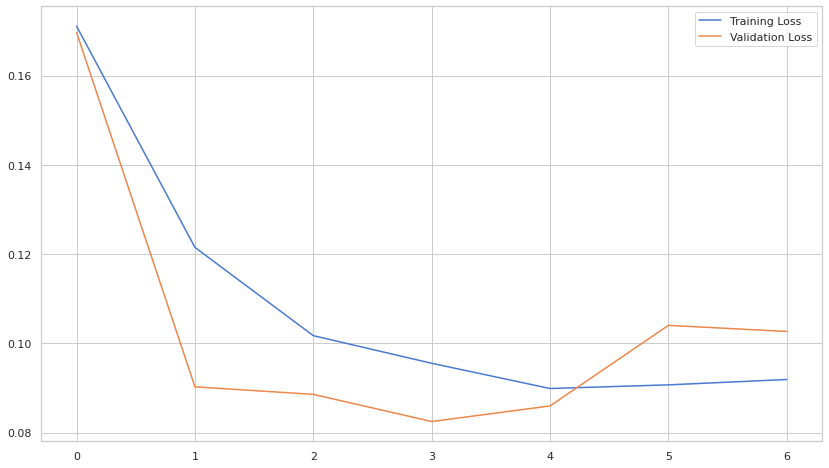

In [36]:
plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.legend();

In [37]:
X_train_pred = model.predict(X_train) 
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 25ms/step - loss: 1.0753


1.0752660036087036

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



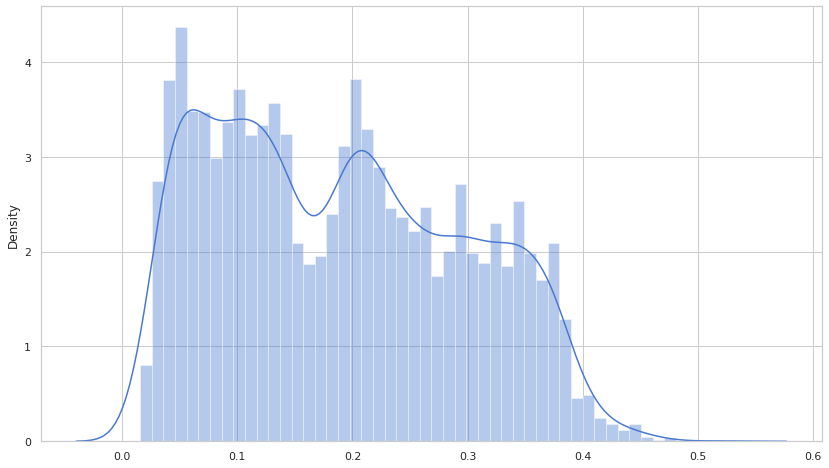

In [38]:
sns.distplot(train_mae_loss, bins=50, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



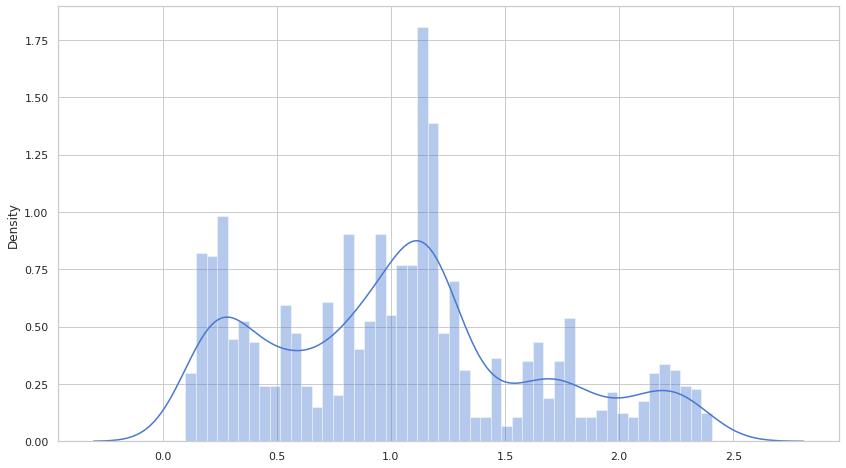

In [39]:
X_test_pred = model.predict(X_test) 
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True);

# Task 8: Detect Anomalies in the S&P 500 Index Data

In [40]:
THRESHOLD = 0.65 
test_score_df = pd.DataFrame(test[time_steps:]) 
test_score_df['loss'] = test_mae_loss 
test_score_df['threshold'] = THRESHOLD 
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold 
test_score_df['close'] = test[time_steps:].close

In [41]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.100156,0.65,False
6584,2012-02-09,1.221625,0.103144,0.65,False
6585,2012-02-10,1.199313,0.106591,0.65,False
6586,2012-02-13,1.221194,0.113618,0.65,False
6587,2012-02-14,1.218150,0.116716,0.65,False


In [42]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,2.306611,0.65,True
8188,2018-06-26,4.507583,2.315234,0.65,True
8189,2018-06-27,4.451431,2.318434,0.65,True
8190,2018-06-28,4.491406,2.325070,0.65,True
8191,2018-06-29,4.496343,2.324742,0.65,True


In [43]:
fig = go.Figure() 
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss, mode='lines', name='Test Loss')) 
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, mode='lines', name='Threshold')) 
fig.update_layout(showlegend=True) 
fig.show()